In [20]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os

!pwd
path_current = os.getcwd()
print(path_current.split('/')[-1])
if path_current.split('/')[-1]=="scfair-reproducibility":
    print("we are in the correct directory")
else:
    os.chdir("..")
    print("we are changing directory to")
    !pwd
    
    
from evaluation.metrics import *
from evaluation.evaluate import *
from scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker

/home/jupyter/analysis/scfair_analysis/scfair-reproducibility
scfair-reproducibility
we are in the correct directory


# Kang

In [22]:
# load dataset
adata = sc.read("data/kang2018.h5ad")

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'Kang'

# specify attributes
cats = ['label', 'cell_type']

# specify a path that will be used to save any trained model later (directories in the path should be created first)
pre_path = f"models/FairVI"

# specify a path that will be used to save the preprocessed indices of paired samples for the counterfactual term calculation
# (a directory named "idx_cf_tensors" should be created first)
idx_cf_tensor_path = f'idx_cf_tensors/kang'

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

today = datetime.today().strftime('%Y-%m-%d')

adata

AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'label_idx', 'cell_type_idx'
    var: 'name', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

# scVI

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="label")
vae = scvi.model.SCVI(adata)
vae.train()
vae.save("models/scVI")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 36/324:  11%|█         | 35/324 [01:28<12:21,  2.57s/it, v_num=1, train_loss_step=258, train_loss_epoch=282]

In [26]:
torch.cuda.is_available()


True

In [3]:
vae = scvi.model.SCVI.load("models/scVI", adata=adata)
adata.obsm["scVI"] = vae.get_latent_representation()

INFO     File models/scVI/model.pt already downloaded                                                              


# scANVI

In [5]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
lvae.save("models/scANVI")

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 20/20: 100%|██████████| 20/20 [01:12<00:00,  3.55s/it, v_num=1, train_loss_step=358, train_loss_epoch=336]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it, v_num=1, train_loss_step=358, train_loss_epoch=336]


In [4]:
lvae = scvi.model.SCANVI.load("models/scANVI", adata=adata)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO     File models/scANVI/model.pt already downloaded                                                            


# scFair

In [5]:
epochs = 400
batch_size = 256
cf_weight = 1
alpha = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
mode=(0,1,2,3,4)
cf_mode = 0

pre_path = '/lustre/scratch126/cellgen/team205/ml19/scfair/scfair/results_transcriptomic/models/FairVI'
idx_cf_tensor_path = '/lustre/scratch126/cellgen/team205/ml19/scfair/scfair/idx_cf_tensors/July10_kang_fixed_pairing'

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'alpha': alpha, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'mode': mode, 'cf_mode': cf_mode}

model_name = '4Aug_' + '_'.join(k + '=' + str(v) for k, v in train_dict.items())

model = FairVI.load(f"{pre_path}/{model_name}", adata=adata)
model.idx_cf_tensor_path = idx_cf_tensor_path
adata.obsm['scFair'] = model.get_latent_representation(nullify_cat_covs_indices=[0], nullify_shared=True)


INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/ml19/scfair/scfair/results_transcriptomic/models/FairVI/4Aug_max_epochs
         =400_batch_size=256_cf_weight=1_alpha=1_clf_weight=50_adv_clf_weight=10_adv_period=1_mode=(0, 1, 2, 3,    
         4)_cf_mode=0/model.pt already downloaded                                                                  


# UMAP

---UMAP for Z_scVI---


/lustre/scratch126/cellgen/team205/ks32/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/ks32/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/ks32/conda/li

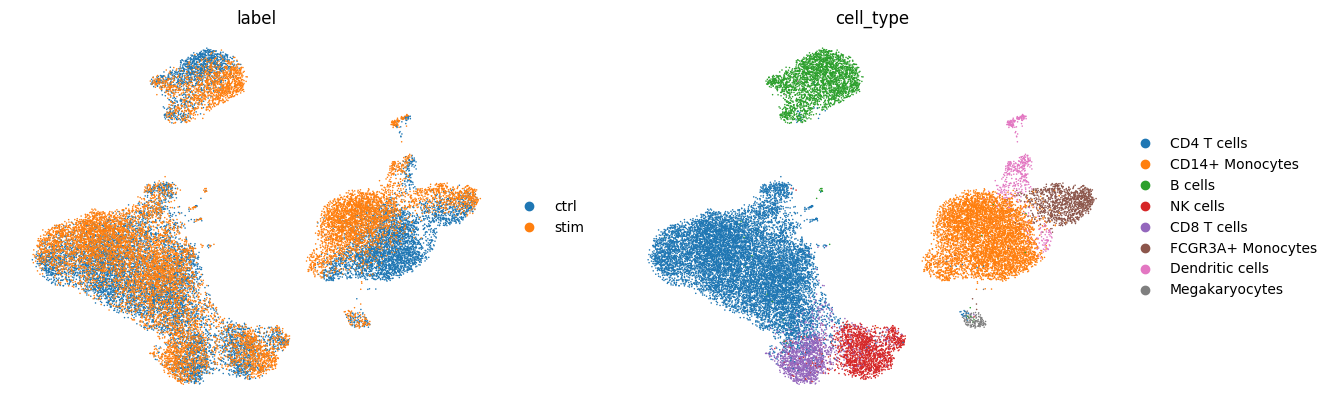

---UMAP for Z_scANVI---


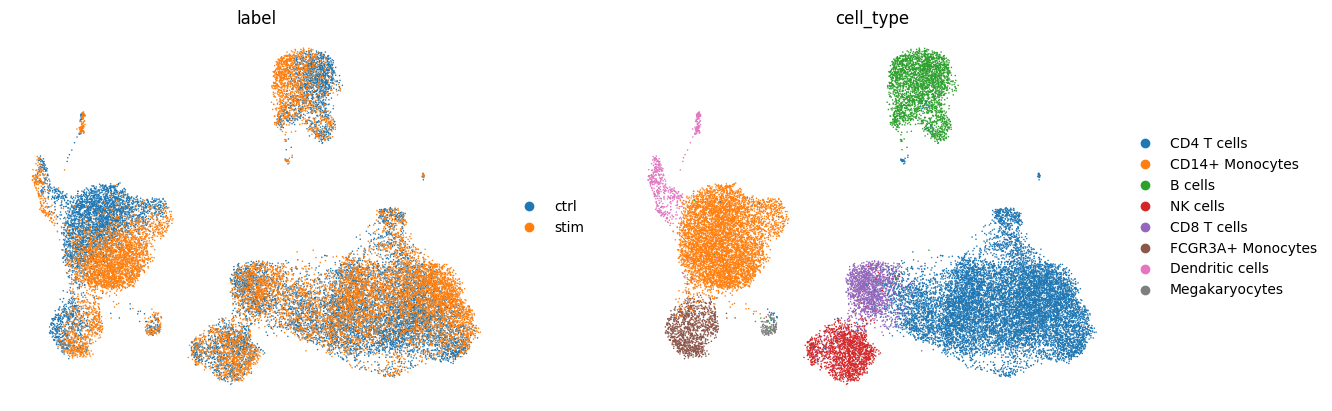

---UMAP for Z_scFair---


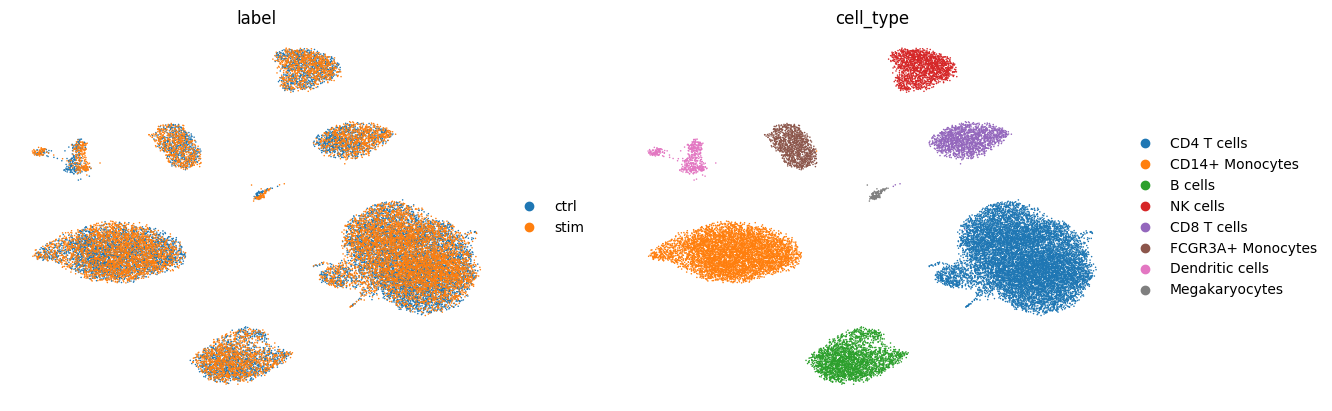

In [9]:
for name in ['scVI', 'scANVI', 'scFair']:
    
    print(f"---UMAP for Z_{name}---")

    sc.pp.neighbors(adata, use_rep=name)
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

# scib benchmark

In [1]:
import jax.numpy as jnp
jnp.bincount(jnp.array([0, 1]))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([1, 1], dtype=int32)

In [6]:
batch_key = cats[0]
label_key = cats[1]

print(f'scib benchmark metrics for (batch_key={batch_key}, label_key={label_key})')

bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=label_key,
    embedding_obsm_keys=['scVI', 'scANVI', 'scFair'],
    n_jobs=3,
)
bm.benchmark()

bm.plot_results_table(min_max_scale=False)

scib benchmark metrics for (batch_key=label, label_key=cell_type)


/lustre/scratch126/cellgen/team205/ks32/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/ks32/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/ks32/conda/li

XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.